In [1]:
import pyedflib
import mne
import numpy as np
from scipy.io import savemat
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import interp1d
from scipy.io import savemat, loadmat


# Load the EDF file
edf_path = '../data/201 N1.edf'
raw = mne.io.read_raw_edf(edf_path, preload=True)

# Convert to microvolts
raw._data *= 1e6  # Convert from volts to microvolts
print(f"After conversion to μV - Min: {raw._data.min():.2f}, Max: {raw._data.max():.2f}")

# Bandpass filter from 0.5 to 50 Hz
raw.filter(0.5, 50, fir_design='firwin')
print(f"After filtering - Min: {raw._data.min():.2f}, Max: {raw._data.max():.2f}")

# Downsample to 100 Hz
raw.resample(100)
print(f"After resampling - Min: {raw._data.min():.2f}, Max: {raw._data.max():.2f}")

# Print out the channel names in the raw EDF data
print("Channel names:", raw.ch_names)

# Create bipolar montage
bipolar_montage = mne.set_bipolar_reference(
    raw,
    anode=['F3-M2', 'C3-M2', 'F4-M1', 'C4-M1'],
    cathode=['C3-M2', 'O1-M2', 'C4-M1', 'O2-M1'],
    ch_name=['F3-C3', 'C3-O1', 'F4-C4', 'C4-O2']
)

# Pick only the bipolar channels
raw = bipolar_montage.pick_channels(['F3-C3', 'C3-O1', 'F4-C4', 'C4-O2'])
print(f"After bipolar montage - Min: {raw._data.min():.2f}, Max: {raw._data.max():.2f}")

# Segment into 30-second epochs
epochs = mne.make_fixed_length_epochs(raw, duration=30, preload=True)
print(f"After epoching - Min: {epochs._data.min():.2f}, Max: {epochs._data.max():.2f}")

Extracting EDF parameters from /Users/jackkrolik/Downloads/Code/eeg-sleepstage-classifier/data/201 N1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8952199  =      0.000 ... 44760.995 secs...


/var/folders/4f/sgn_zcm52nl7hs_clb0tdbph0000gn/T/ipykernel_12591/2832317485.py:13: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
/var/folders/4f/sgn_zcm52nl7hs_clb0tdbph0000gn/T/ipykernel_12591/2832317485.py:13: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


After conversion to μV - Min: -60257.68, Max: 999221.79
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


After filtering - Min: -468588.63, Max: 468588.63
After resampling - Min: -464247.88, Max: 468712.50
Channel names: ['LOC', 'ROC', 'F3-M2', 'F4-M1', 'C3-M2', 'C4-M1', 'P3-M2', 'P4-M1', 'O1-M2', 'O2-M1', 'Chin', 'Chest', 'Abdomen', 'SAO2', 'Airflow', 'EKG', 'Snore', 'R-R', 'CPAP']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=4, n_times=4476100
    Range : 0 ... 4476099 =      0.000 ... 44760.990 secs
Ready.
Added the following bipolar channels:
F3-C3, C3-O1, F4-C4, C4-O2
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
After bipolar montage - Min: -7827.74, Max: 7724.69
Not setting metadata
1492 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1492 events and 3000 original time points ...
0 bad epochs dropped
After epoching - Min: -7827.74, Max: 7724.69


Dropped 0 epochs: 
Total interpolated amplitude artifacts in kept epochs: 34336
Total interpolated flat signal artifacts in kept epochs: 0
Total amplitude artifacts in removed epochs: 0
Total flat signal artifacts in removed epochs: 0
Number of epochs removed due to long artifacts: 0
After artifact handling - Min: -499.90, Max: 499.96
After scaling - Min: -499.90, Max: 499.96
[[-1 -1 -1 ... -1 -1 -1]]
Data saved successfully.


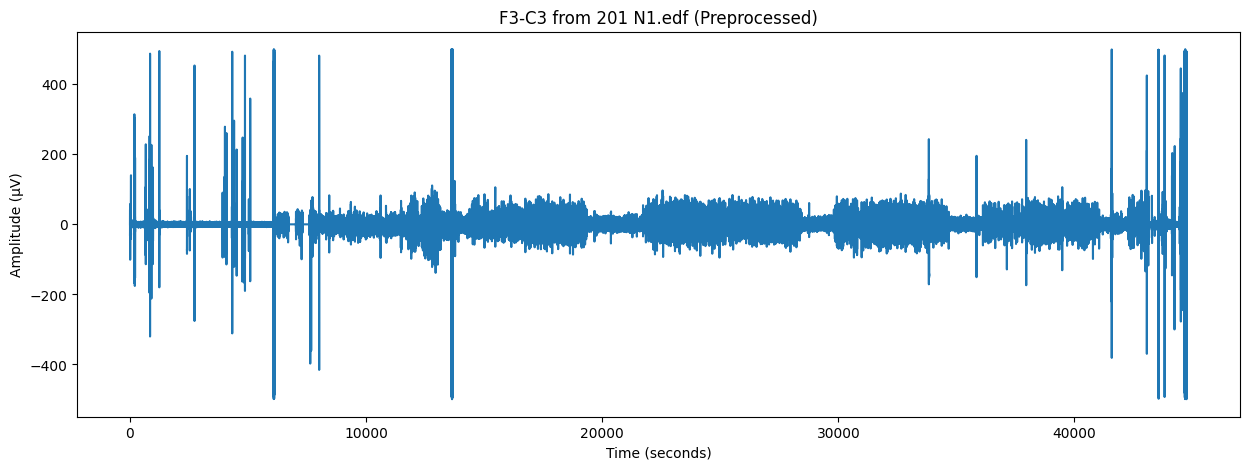

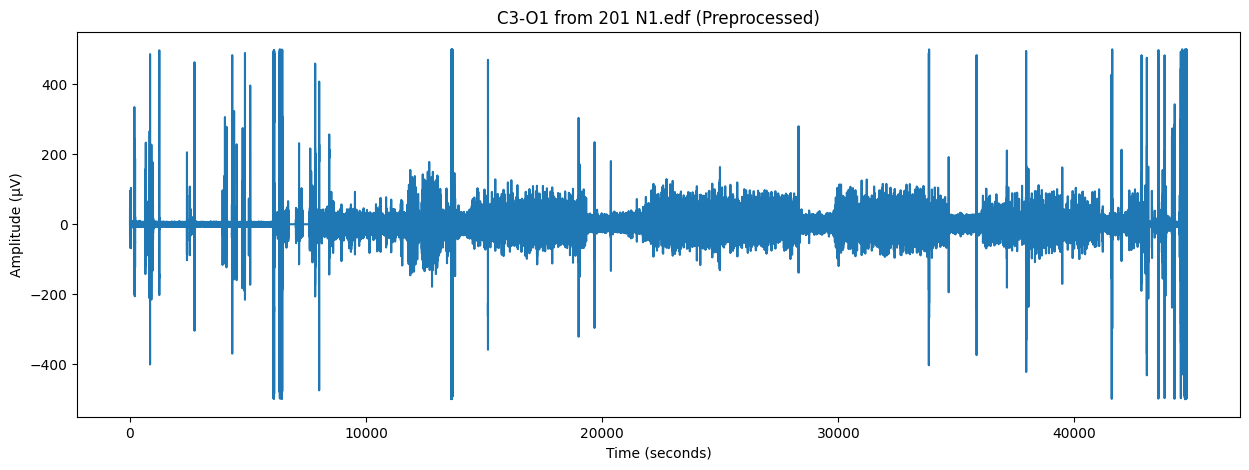

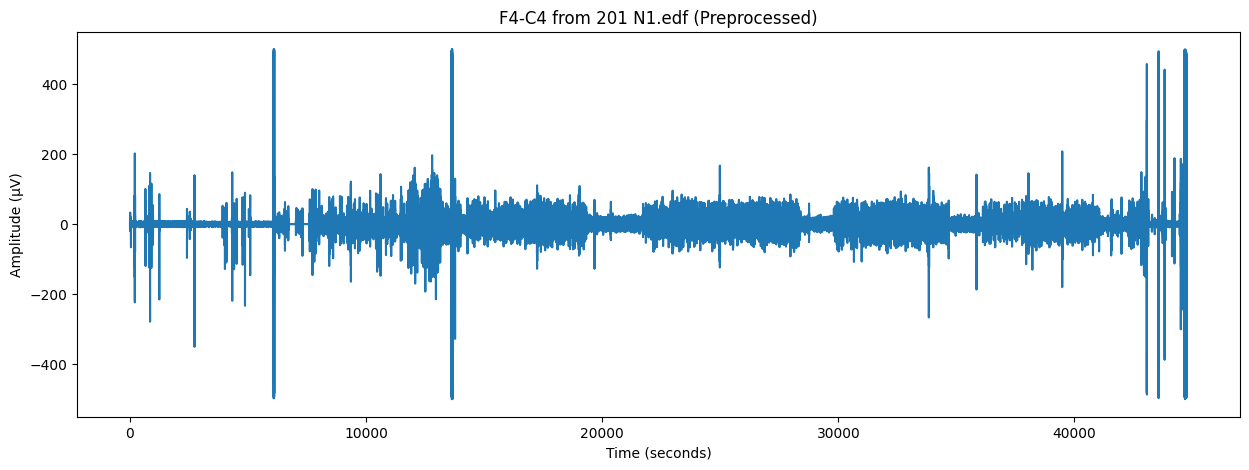

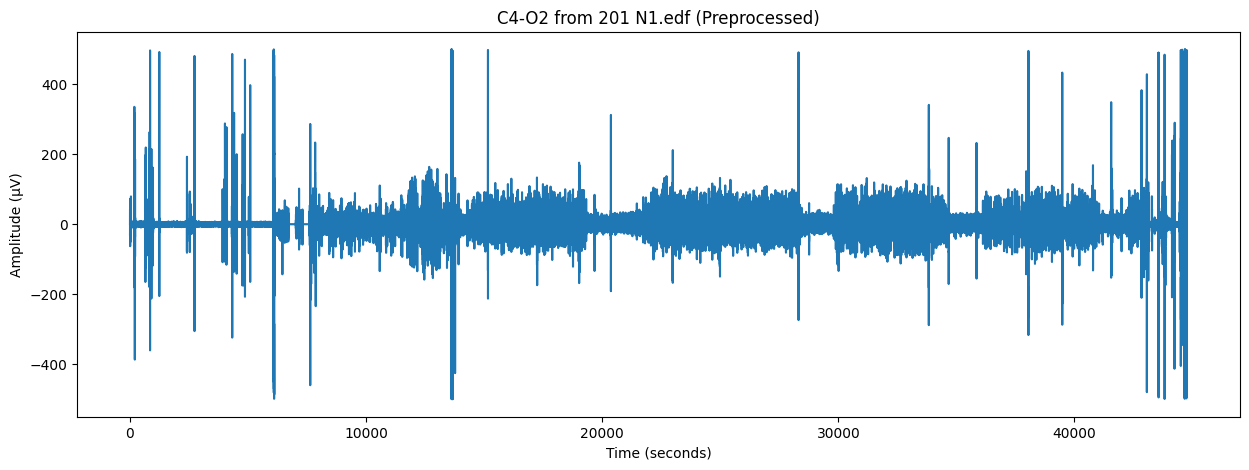

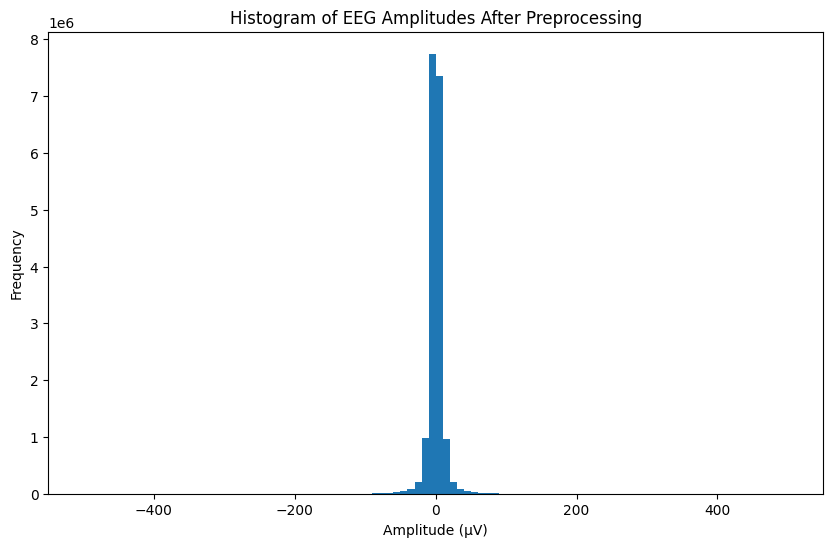

Final data range: -499.90 to 499.96 μV


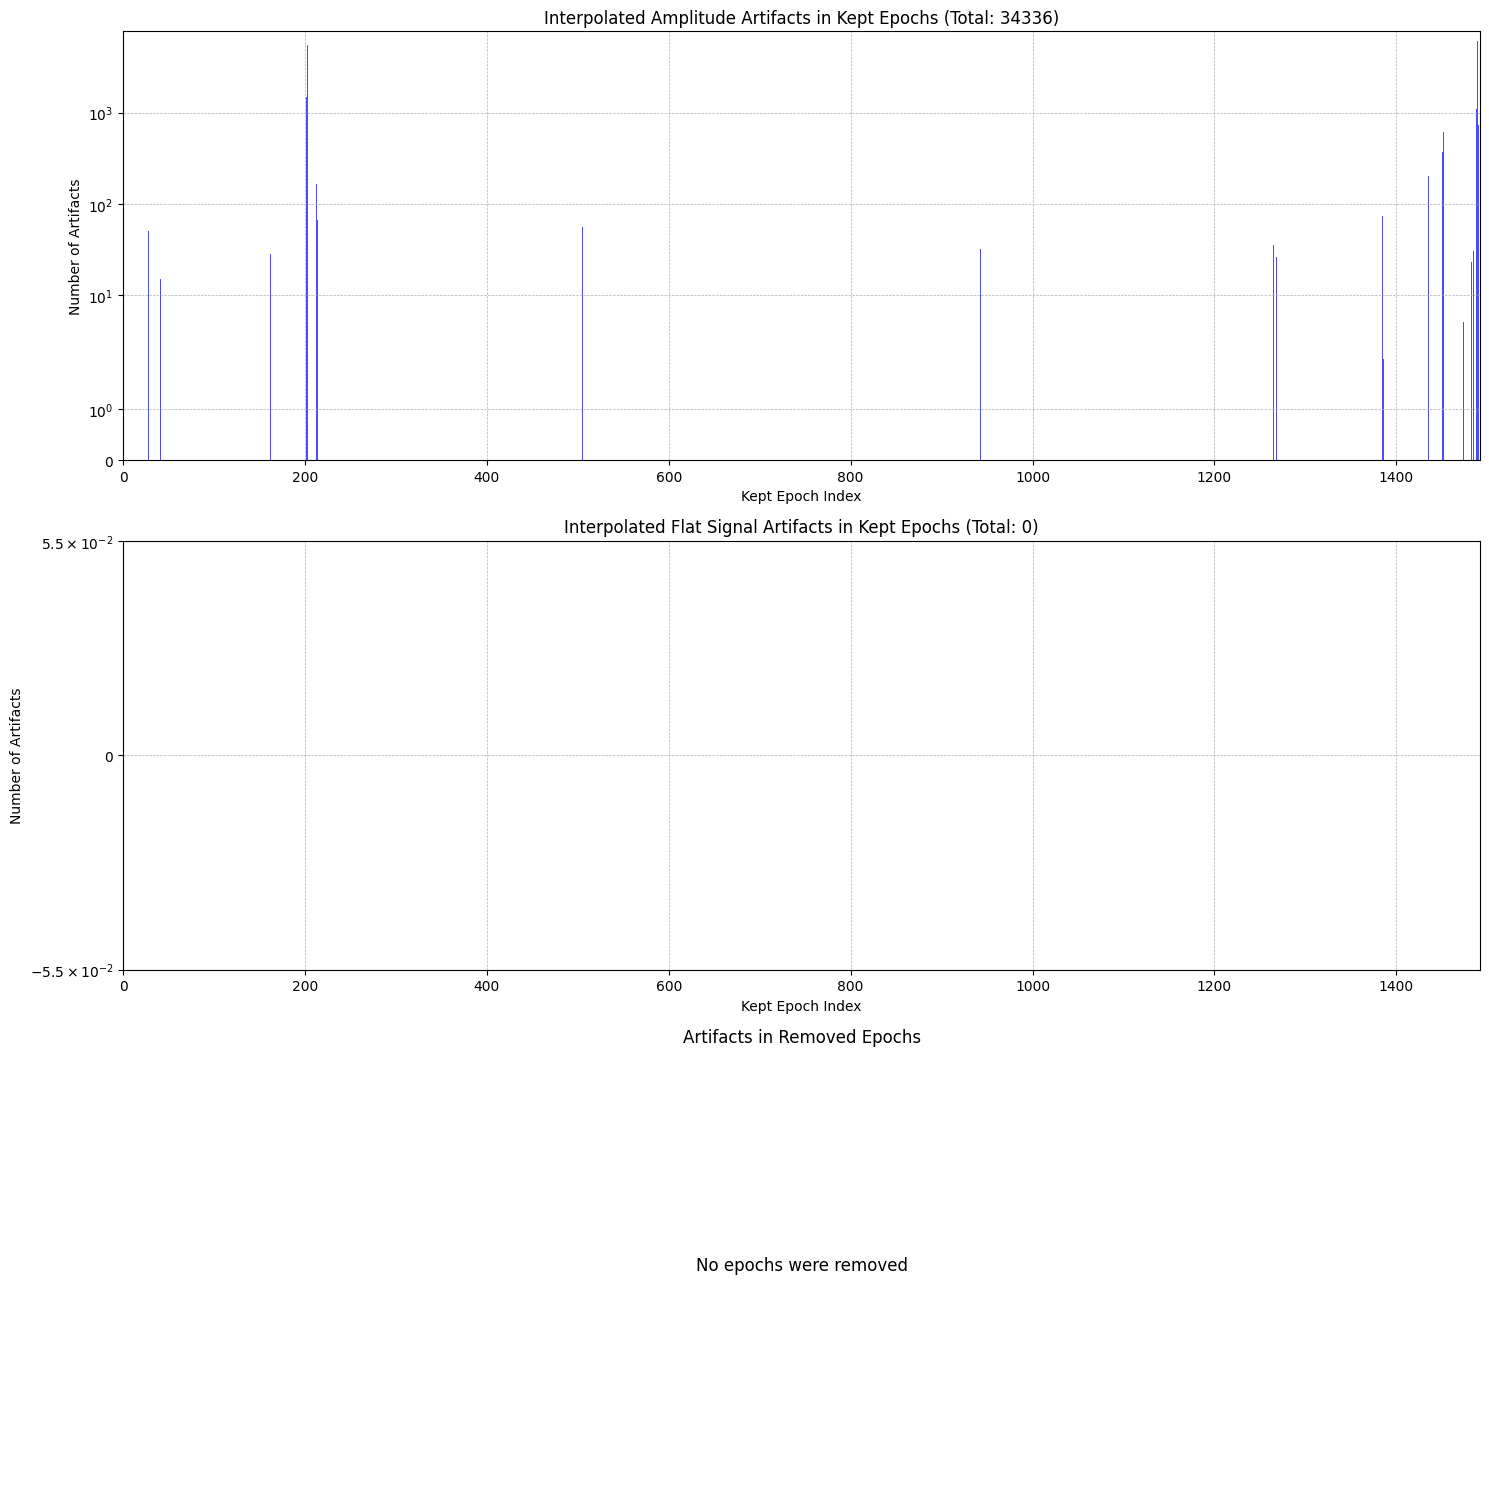

In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# Modified artifact detection function to return separate masks
def detect_artifacts(data, threshold=500, flat_threshold=1e-6, flat_duration=5, sfreq=100):
    # Detect amplitude saturation
    amplitude_mask = np.abs(data) > threshold
    
    # Detect flat signals
    diff = np.abs(np.diff(data))
    flat_mask = np.zeros_like(data, dtype=bool)
    flat_samples = int(flat_duration * sfreq)
    for i in range(len(data) - flat_samples):
        if np.all(diff[i:i+flat_samples-1] < flat_threshold):
            flat_mask[i:i+flat_samples] = True
    
    return amplitude_mask, flat_mask

def handle_artifacts(data, artifact_mask):
    data[artifact_mask] = np.nan
    return data

def fill_nan(data):
    mask = np.isnan(data)
    x = np.arange(len(data))
    data[mask] = np.interp(x[mask], x[~mask], data[~mask])
    return data

# def preprocess_sleep_stages(file_path, epochs_to_remove, keep_unscored=False):
#     # Define the mapping for renumbering
#     stage_mapping = {
#         7: 4,  # Wake to 4
#         5: 3,  # REM to 3
#         1: 2,  # Stage 1 to 2 (N1)
#         2: 1,  # Stage 2 to 1 (N2)
#         3: 0,  # Stage 3 to 0 (N3)
#         0: -1  # Assuming 0 means unscored, map it to -1 or handle as needed
#     }

#     with open(file_path, 'r') as file:
#         lines = file.readlines()
    
#     # Skip the first two lines (timestamp information)
#     data = [line.strip().split() for line in lines[2:]]
    
#     # Extract the first column (sleep stage scores)
#     sleep_stages = [int(row[0]) for row in data]

#     if keep_unscored:
#         processed_stages = sleep_stages
#     else:
#         # Find the index of the first and last wake state (7)
#         start_index = sleep_stages.index(7)
#         end_index = len(sleep_stages) - sleep_stages[::-1].index(7)
        
#         # Extract the relevant sleep stages
#         processed_stages = sleep_stages[start_index:end_index]
    
#     # Renumber the stages according to the mapping
#     renumbered_stages = [stage_mapping.get(stage, stage) for stage in processed_stages]
    
#     # Convert to numpy array with shape (1, # of sleep scores)
#     np_stages = np.array(renumbered_stages).reshape(1, -1)

#     # Remove sleep stages corresponding to removed epochs
#     np_stages = np.delete(np_stages, list(epochs_to_remove), axis=1)

#     return np_stages


def preprocess_sleep_stages(file_path, epochs_to_remove, keep_unscored=False):
    # Define the mapping for renumbering
    stage_mapping = {
        7: 4,  # Wake to 4
        5: 3,  # REM to 3
        1: 2,  # Stage 1 to 2 (N1)
        2: 1,  # Stage 2 to 1 (N2)
        3: 0,  # Stage 3 to 0 (N3)
        0: -1  # Assuming 0 means unscored, map it to -1 or handle as needed
    }

    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Skip the first two lines (timestamp information)
    data = [line.strip().split() for line in lines[2:]]
    
    # Extract the first column (sleep stage scores)
    sleep_stages = [int(row[0]) for row in data]

    # Find the index of the first and last wake state (7)
    start_index = sleep_stages.index(7)
    end_index = len(sleep_stages) - sleep_stages[::-1].index(7)

    # Ensure 50 awake states at the beginning
    for i in range(max(0, start_index - 50), start_index):
        if sleep_stages[i] == 0:  # If unscored
            sleep_stages[i] = 7  # Change to awake
    start_index = max(0, start_index - 50)

    # Ensure 50 awake states at the end
    for i in range(end_index, min(len(sleep_stages), end_index + 50)):
        if sleep_stages[i] == 0:  # If unscored
            sleep_stages[i] = 7  # Change to awake
    end_index = min(len(sleep_stages), end_index + 50)

    if keep_unscored:
        processed_stages = sleep_stages
    else:
        # Extract the relevant sleep stages
        processed_stages = sleep_stages[start_index:end_index]
    
    # Renumber the stages according to the mapping
    renumbered_stages = [stage_mapping.get(stage, stage) for stage in processed_stages]
    
    # Convert to numpy array with shape (1, # of sleep scores)
    np_stages = np.array(renumbered_stages).reshape(1, -1)

    # Remove sleep stages corresponding to removed epochs
    np_stages = np.delete(np_stages, list(epochs_to_remove), axis=1)

    return np_stages

# Initialize arrays to track artifacts
amplitude_artifact_counts = np.zeros(epochs._data.shape[0])
flat_artifact_counts = np.zeros(epochs._data.shape[0])
epochs_to_remove = set()

# Apply artifact detection and handling
for i in range(epochs._data.shape[0]):  # Loop through epochs
    for j in range(epochs._data.shape[1]):  # Loop through channels
        amplitude_mask, flat_mask = detect_artifacts(epochs._data[i, j, :], sfreq=raw.info['sfreq'])
        
        amplitude_artifact_counts[i] += np.sum(amplitude_mask)
        flat_artifact_counts[i] += np.sum(flat_mask)
        
        amplitude_labeled, _ = ndimage.label(amplitude_mask)
        flat_labeled, _ = ndimage.label(flat_mask)
        
        amplitude_consecutive = ndimage.sum(amplitude_mask, amplitude_labeled, range(1, amplitude_labeled.max() + 1))
        flat_consecutive = ndimage.sum(flat_mask, flat_labeled, range(1, flat_labeled.max() + 1))
        
        if np.any(amplitude_consecutive >= 5 * raw.info['sfreq']) or np.any(flat_consecutive >= 5 * raw.info['sfreq']):
            epochs_to_remove.add(i)
            break
        
        epochs._data[i, j, :] = handle_artifacts(epochs._data[i, j, :], amplitude_mask | flat_mask)

# Separate the artifact counts for kept and removed epochs
kept_amplitude_counts = np.delete(amplitude_artifact_counts, list(epochs_to_remove))
kept_flat_counts = np.delete(flat_artifact_counts, list(epochs_to_remove))
removed_amplitude_counts = amplitude_artifact_counts[list(epochs_to_remove)]
removed_flat_counts = flat_artifact_counts[list(epochs_to_remove)]

# Remove marked epochs
epochs.drop(list(epochs_to_remove))

print(f"Total interpolated amplitude artifacts in kept epochs: {int(np.sum(kept_amplitude_counts))}")
print(f"Total interpolated flat signal artifacts in kept epochs: {int(np.sum(kept_flat_counts))}")
print(f"Total amplitude artifacts in removed epochs: {int(np.sum(removed_amplitude_counts))}")
print(f"Total flat signal artifacts in removed epochs: {int(np.sum(removed_flat_counts))}")
print(f"Number of epochs removed due to long artifacts: {len(epochs_to_remove)}")


# Fill NaN values
for i in range(epochs._data.shape[0]):  # Loop through epochs
    for j in range(epochs._data.shape[1]):  # Loop through channels
        epochs._data[i, j, :] = fill_nan(epochs._data[i, j, :])

print(f"After artifact handling - Min: {epochs._data.min():.2f}, Max: {epochs._data.max():.2f}")

# Scale each channel
for i, ch in enumerate(raw.ch_names):
    data = epochs.get_data(picks=ch).reshape(-1)
    median = np.median(data)
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    scaled_data = (data - median) / iqr * iqr + median
    epochs._data[:, epochs.ch_names.index(ch), :] = scaled_data.reshape(epochs._data.shape[0], -1)

print(f"After scaling - Min: {epochs._data.min():.2f}, Max: {epochs._data.max():.2f}")

# Usage
file_path = '../data/Sleep Stages 201_N1.txt'  # Replace with the actual file path
result = preprocess_sleep_stages(file_path, epochs_to_remove, keep_unscored=True)
print(result)

# Extract preprocessed data (without the need for transposition)
preprocessed_data = epochs.get_data()

# Create a dictionary for saving (no transposition required here)
mat_dict = {
    'sig1': preprocessed_data[:, 0, :],  # Save directly, no .T
    'sig2': preprocessed_data[:, 1, :],  
    'sig3': preprocessed_data[:, 2, :],  
    'sig4': preprocessed_data[:, 3, :],  
    'Fs': raw.info['sfreq'],
    'ch_names': raw.ch_names,
    'labels': result  # This now has the same number of epochs as the EEG data
}

# Save as .mat file
try:
    scipy.io.savemat('preprocessed_data_combined.mat', mat_dict)
    print("Data saved successfully.")
except Exception as e:
    print(f"Error saving data: {e}")

# Plotting function
def plot_channel(data, channel_name, fs):
    time = np.arange(len(data)) / fs
    plt.figure(figsize=(15, 5))
    plt.plot(time, data)
    plt.title(f'{channel_name} from 201 N1.edf (Preprocessed)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (μV)')
    plt.show()

# Plot each channel
for i, ch_name in enumerate(raw.ch_names):
    plot_channel(preprocessed_data[:, i, :].flatten(), ch_name, raw.info['sfreq'])

# Histogram of amplitudes
plt.figure(figsize=(10, 6))
plt.hist(preprocessed_data.flatten(), bins=100)
plt.title('Histogram of EEG Amplitudes After Preprocessing')
plt.xlabel('Amplitude (μV)')
plt.ylabel('Frequency')
plt.show()

# Data quality check function
def check_data_quality(data):
    if np.isnan(data).any():
        print("Warning: NaN values detected in preprocessed data.")
    if np.isinf(data).any():
        print("Warning: Infinite values detected in preprocessed data.")
    print(f"Final data range: {data.min():.2f} to {data.max():.2f} μV")

check_data_quality(preprocessed_data)

# Plotting the frequency of artifacts
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# Plot for kept epochs - Amplitude artifacts
ax[0].bar(np.arange(len(kept_amplitude_counts)), kept_amplitude_counts, color='blue', alpha=0.7)
ax[0].set_title(f'Interpolated Amplitude Artifacts in Kept Epochs (Total: {int(np.sum(kept_amplitude_counts))})')
ax[0].set_xlabel('Kept Epoch Index')
ax[0].set_ylabel('Number of Artifacts')
ax[0].set_xlim(0, max(1, len(kept_amplitude_counts)))
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[0].set_yscale('symlog')

# Plot for kept epochs - Flat signal artifacts
ax[1].bar(np.arange(len(kept_flat_counts)), kept_flat_counts, color='red', alpha=0.7)
ax[1].set_title(f'Interpolated Flat Signal Artifacts in Kept Epochs (Total: {int(np.sum(kept_flat_counts))})')
ax[1].set_xlabel('Kept Epoch Index')
ax[1].set_ylabel('Number of Artifacts')
ax[1].set_xlim(0, max(1, len(kept_flat_counts)))
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[1].set_yscale('symlog')

# Plot for removed epochs - Both types of artifacts
if len(removed_amplitude_counts) > 0:
    ax[2].bar(np.arange(len(removed_amplitude_counts)), removed_amplitude_counts, color='blue', alpha=0.7, label='Amplitude')
    ax[2].bar(np.arange(len(removed_flat_counts)), removed_flat_counts, color='red', alpha=0.7, label='Flat Signal')
    ax[2].set_title(f'Artifacts in Removed Epochs (Amplitude: {int(np.sum(removed_amplitude_counts))}, Flat: {int(np.sum(removed_flat_counts))})')
    ax[2].set_xlabel('Removed Epoch Index')
    ax[2].set_ylabel('Number of Artifacts')
    ax[2].set_xlim(0, len(removed_amplitude_counts))
    ax[2].grid(True, which='both', linestyle='--', linewidth=0.5)
    ax[2].set_yscale('symlog')
    ax[2].legend()
else:
    ax[2].text(0.5, 0.5, 'No epochs were removed', ha='center', va='center', fontsize=12)
    ax[2].set_title('Artifacts in Removed Epochs')
    ax[2].axis('off')

plt.tight_layout()
plt.show()

In [3]:
print("Number of sleep stages", mat_dict['labels'].shape[1])
print("Number of epochs", preprocessed_data.shape[0])

Number of sleep stages 1492
Number of epochs 1492


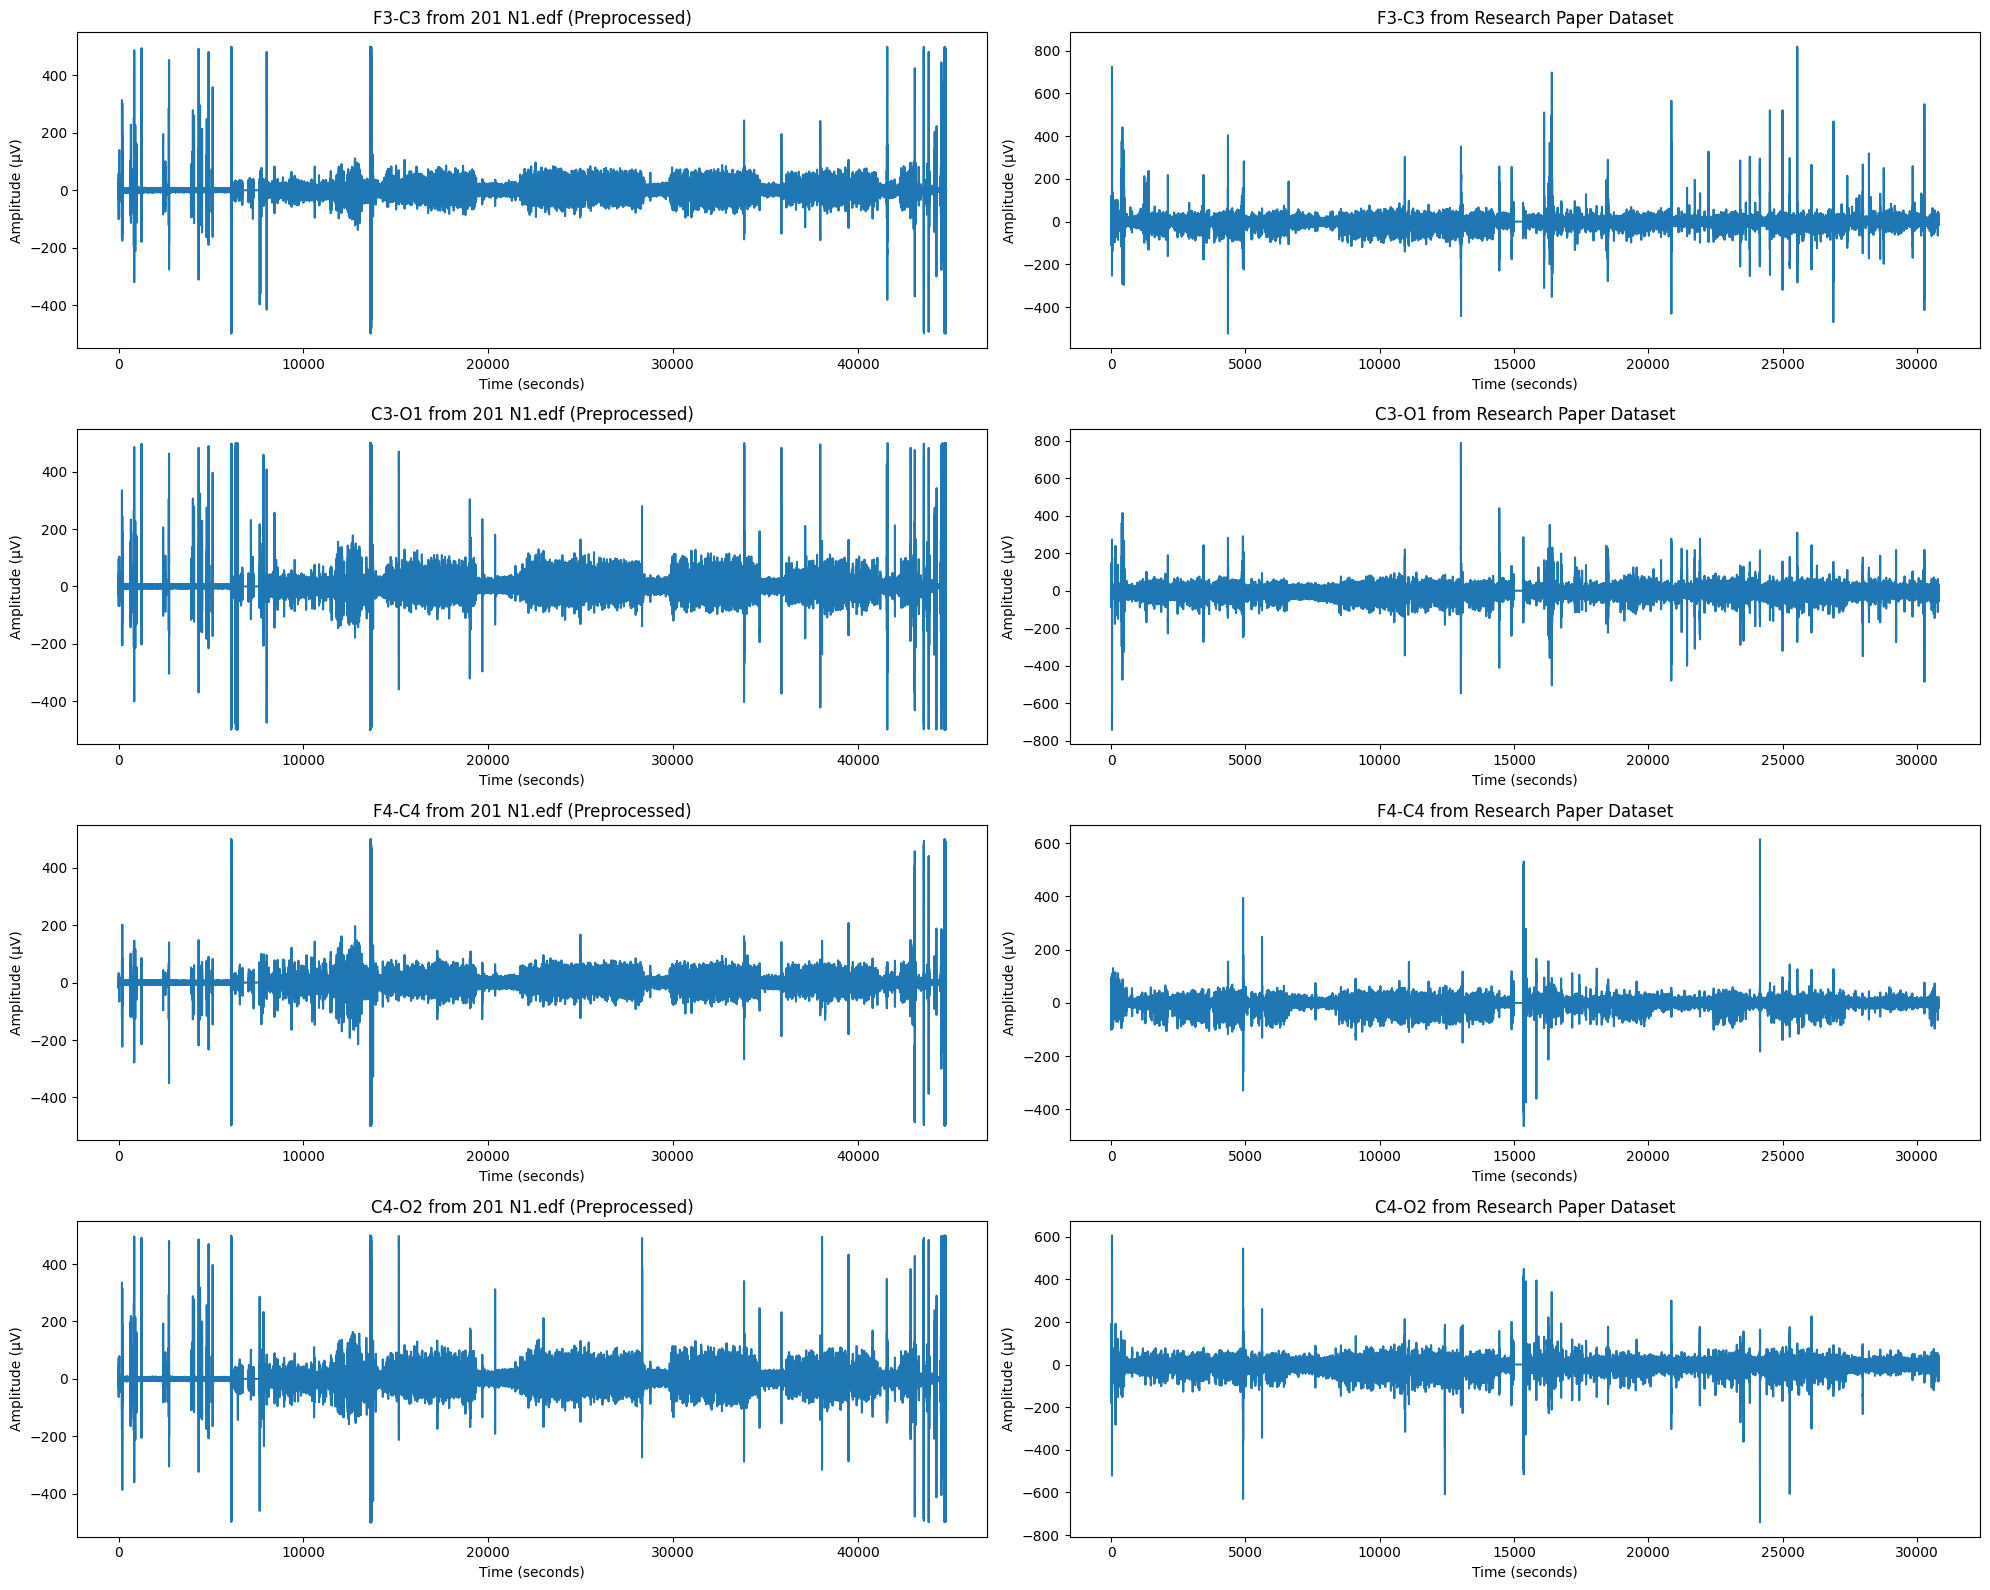

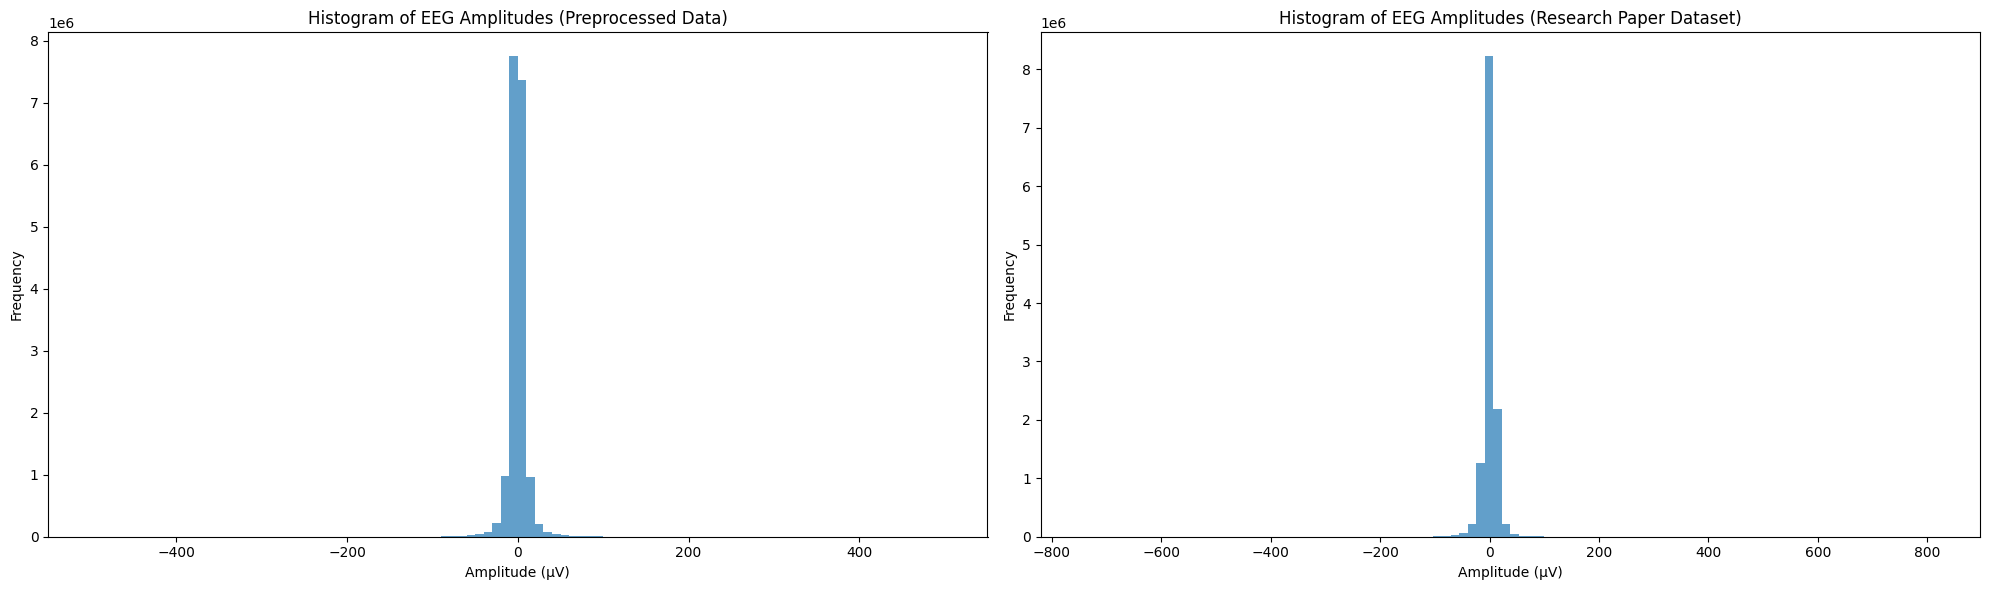

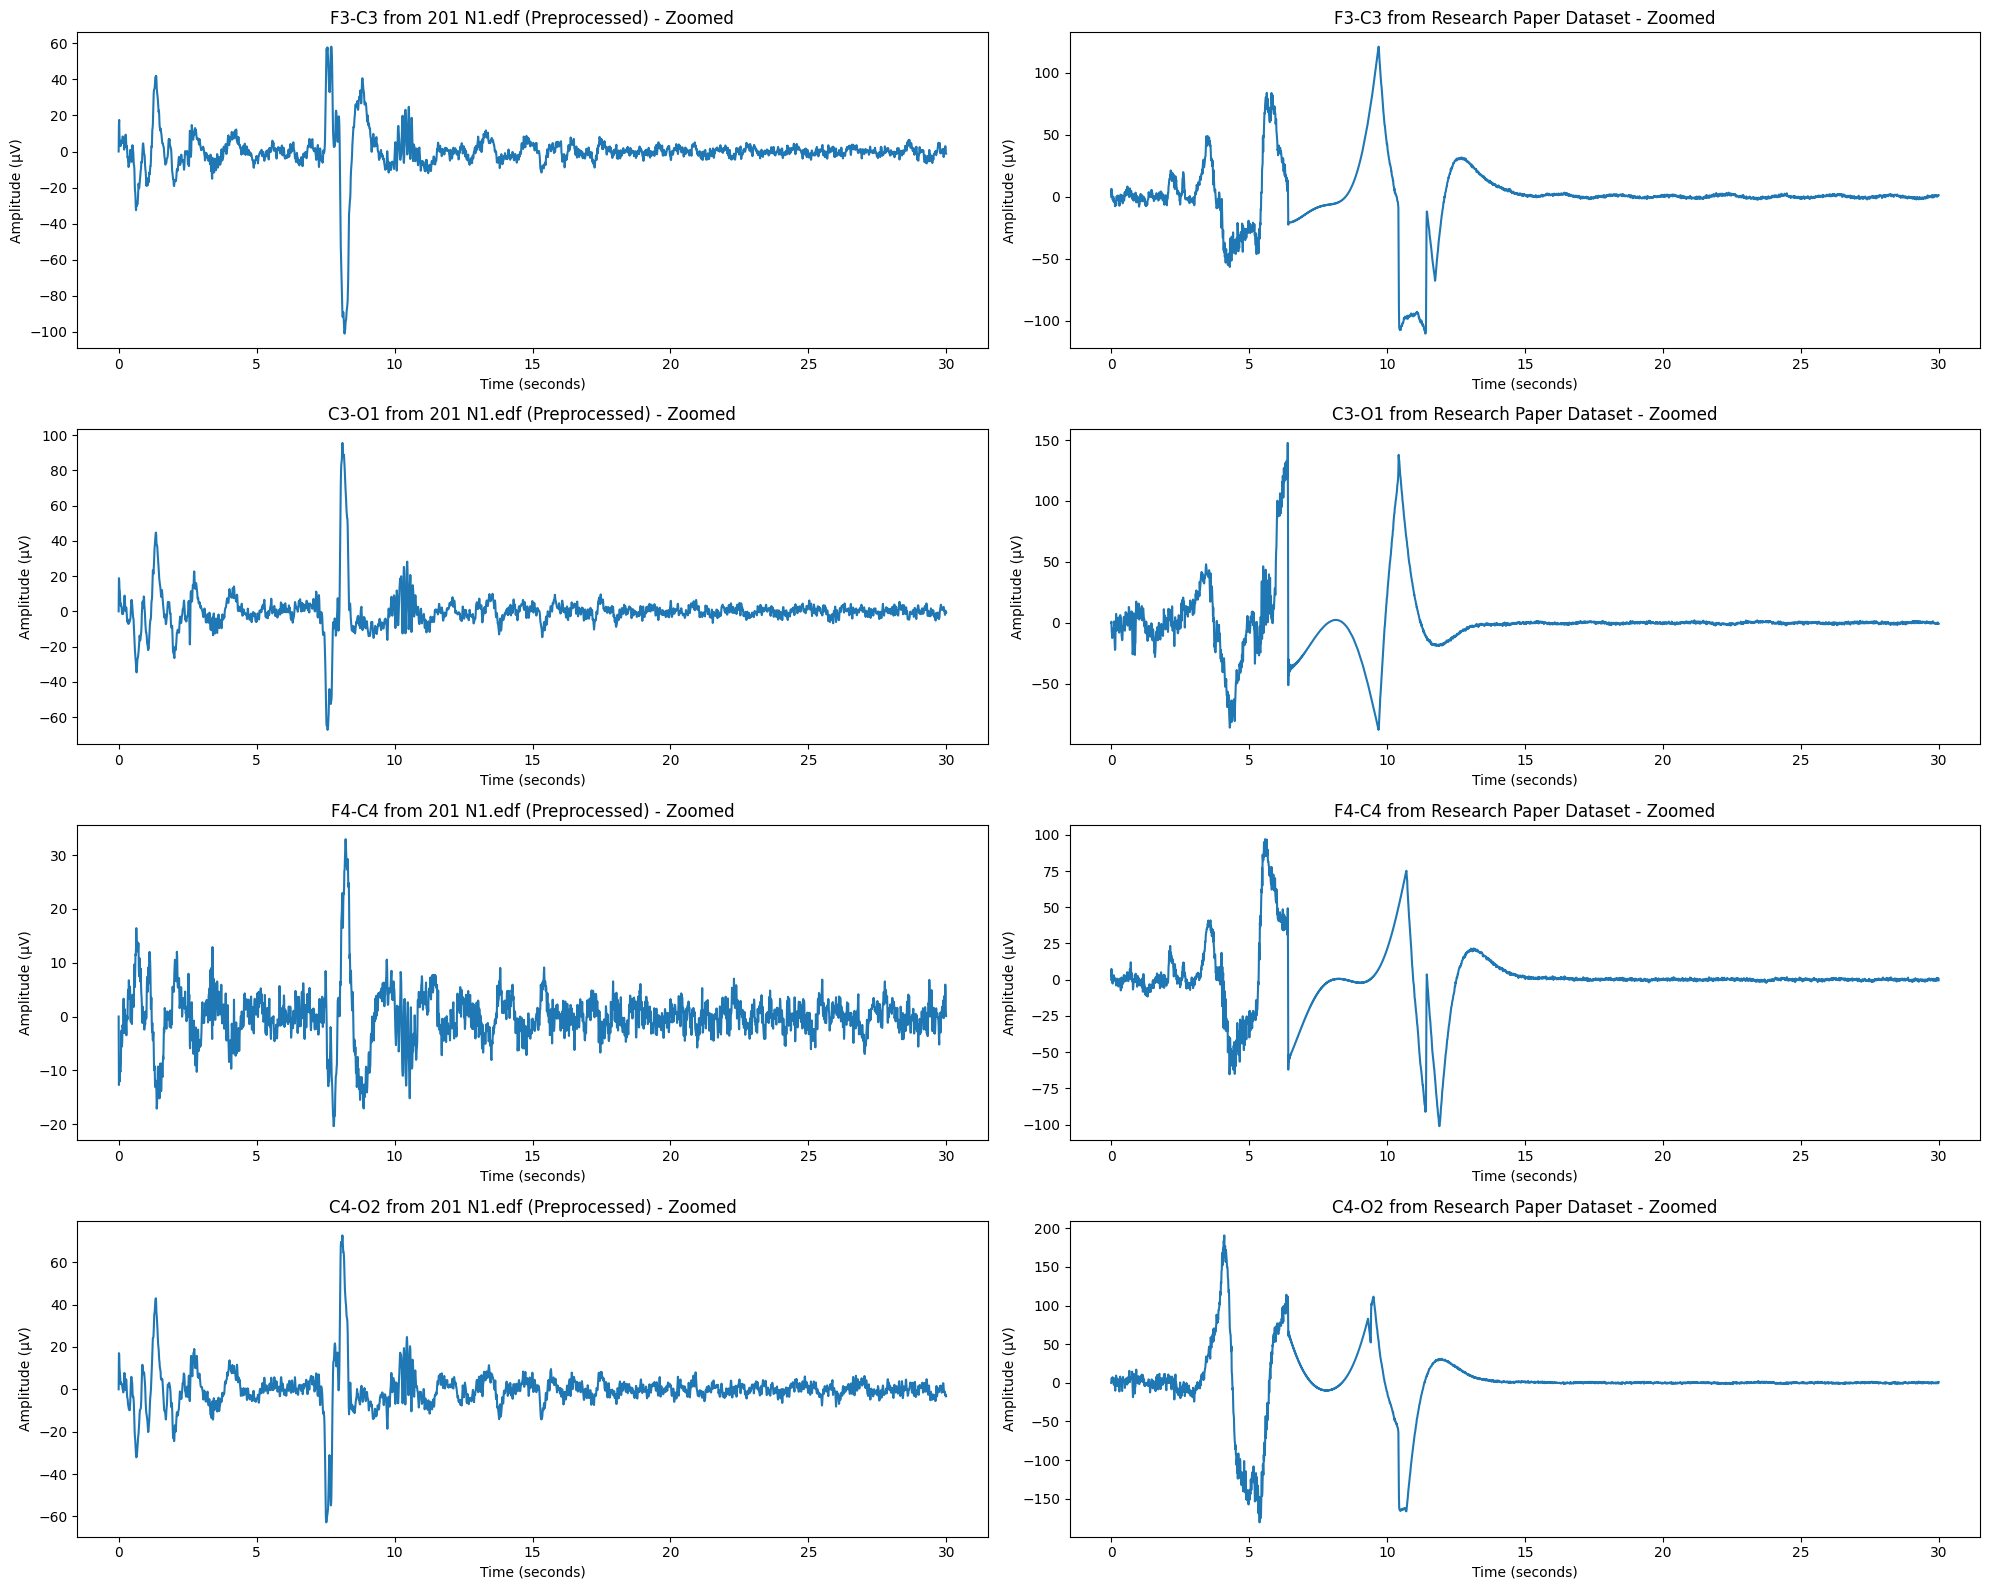

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io

# Load the first .mat file (your preprocessed data)
mat_data_1 = scipy.io.loadmat('./preprocessed_data_combined.mat')
signals_file1 = [np.squeeze(mat_data_1['sig1']), np.squeeze(mat_data_1['sig2']), 
                 np.squeeze(mat_data_1['sig3']), np.squeeze(mat_data_1['sig4'])]  # No need for .T
Fs_file1 = np.squeeze(mat_data_1['Fs'])
ch_names = mat_data_1['ch_names'].flatten().tolist()  # Extract channel names

# Load the second .mat file (research dataset)
mat_data_2 = scipy.io.loadmat('../data/data.mat')
signals_file2 = [np.squeeze(mat_data_2['sig1']), np.squeeze(mat_data_2['sig2']), 
                 np.squeeze(mat_data_2['sig3']), np.squeeze(mat_data_2['sig4'])]
Fs_file2 = np.squeeze(mat_data_2['Fs'])

# Flatten the signals (flatten to 1D for each channel's data)
signals_file1_flat = [sig.flatten() for sig in signals_file1]  # Correct flattening
signals_file2_flat = [sig.flatten() for sig in signals_file2]

# Create time vectors for both datasets
time_file1 = [np.arange(sig.shape[0]) / Fs_file1 for sig in signals_file1_flat]
time_file2 = [np.arange(sig.shape[0]) / Fs_file2 for sig in signals_file2_flat]

# Plot all signals for both datasets side by side
fig, axes = plt.subplots(4, 2, figsize=(20, 16))

for i in range(4):
    # Plot signals from File 1 (left column)
    axes[i, 0].plot(time_file1[i], signals_file1_flat[i])
    axes[i, 0].set_title(f'{ch_names[i]} from 201 N1.edf (Preprocessed)')
    axes[i, 0].set_xlabel('Time (seconds)')
    axes[i, 0].set_ylabel('Amplitude (μV)')
    
    # Plot signals from File 2 (right column)
    axes[i, 1].plot(time_file2[i], signals_file2_flat[i])
    axes[i, 1].set_title(f'{ch_names[i]} from Research Paper Dataset')
    axes[i, 1].set_xlabel('Time (seconds)')
    axes[i, 1].set_ylabel('Amplitude (μV)')

plt.tight_layout()
plt.show()

# Histogram of amplitudes
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

axes[0].hist(np.concatenate(signals_file1_flat), bins=100, alpha=0.7)
axes[0].set_title('Histogram of EEG Amplitudes (Preprocessed Data)')
axes[0].set_xlabel('Amplitude (μV)')
axes[0].set_ylabel('Frequency')

axes[1].hist(np.concatenate(signals_file2_flat), bins=100, alpha=0.7)
axes[1].set_title('Histogram of EEG Amplitudes (Research Paper Dataset)')
axes[1].set_xlabel('Amplitude (μV)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Zoomed-in plot of a section of data
zoom_duration = 30  # seconds
zoom_samples_file1 = int(zoom_duration * Fs_file1)
zoom_samples_file2 = int(zoom_duration * Fs_file2)

fig, axes = plt.subplots(4, 2, figsize=(20, 16))

for i in range(4):
    # Plot zoomed section from File 1 (left column)
    axes[i, 0].plot(time_file1[i][:zoom_samples_file1], signals_file1_flat[i][:zoom_samples_file1])
    axes[i, 0].set_title(f'{ch_names[i]} from 201 N1.edf (Preprocessed) - Zoomed')
    axes[i, 0].set_xlabel('Time (seconds)')
    axes[i, 0].set_ylabel('Amplitude (μV)')
    
    # Plot zoomed section from File 2 (right column)
    axes[i, 1].plot(time_file2[i][:zoom_samples_file2], signals_file2_flat[i][:zoom_samples_file2])
    axes[i, 1].set_title(f'{ch_names[i]} from Research Paper Dataset - Zoomed')
    axes[i, 1].set_xlabel('Time (seconds)')
    axes[i, 1].set_ylabel('Amplitude (μV)')

plt.tight_layout()
plt.show()
